# CATCH ME IF YOU CAN - a social network analysis

## Introduction
Wagwan

## Group Members:

- **[289791]**: Eliya Allam

- **[283791]**: Mattia Cervelli

- **[286881]**: Davide Pisano
  
- **[287611]**: Giulio Presaghi

- **[283361]**: Marco Tagliavini

## Project Overview:
**[WEEK 1](#week1)** -- Understanding the network we are dealing with

**[WEEK 2](#week2)** -- Insights into local connectivity and overall cohesiveness.

**[WEEK 3](#week3)** -- Dealing with the centralities


## Tools and Technologies Used:

- **Programming Language**: Python
- **Libraries**: Pandas, NumPy, Matplotlib, NetworkX, JSON, HeapQ
- **Platform**: Jupyter Notebook

**LIBRARIES WE ARE GOING TO USE:**

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import heapq
import numpy as np

<a id="week1"></a>

**OPENING THE FILE:**


In [ ]:
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')

The following line takes the *' viz'* column of the *nodes_df* DataFrame and performs two operations:

First, it replaces all single quotes (') with double quotes (") to make the string JSON-compatible.
Then, it parses the modified string as a JSON object, converting it into a *Python dictionary*.

In [ ]:
nodes_df[' viz'] = nodes_df[' viz'].apply(lambda row: row.replace("'", '"')).apply(json.loads)

This section initializes an empty undirected graph G. It then iterates over the rows of nodes_df to add nodes to the graph, and over the rows of edges_df to add edges. Each node and edge is added with its associated attributes.

In [ ]:
G = nx.Graph()

for index, row in nodes_df.iterrows():
    G.add_node(row['# index'], label=row[' label'], viz=row[' viz'])
for index, row in edges_df.iterrows():
    G.add_edge(row['# source'], row[' target'], label=row[' label'], weight=row[' weight'])

positions = {node: (data['viz']['position']['x'], data['viz']['position']['y']) for node, data in G.nodes(data=True)}
colors = [(data['viz']['color']['r']/255, data['viz']['color']['g']/255, data['viz']['color']['b']/255, data['viz']['color']['a']) for node, data in G.nodes(data=True)]
sizes = [data['viz']['size'] * 100 for node, data in G.nodes(data=True)]

*Graph G* is now ready to be visualized.

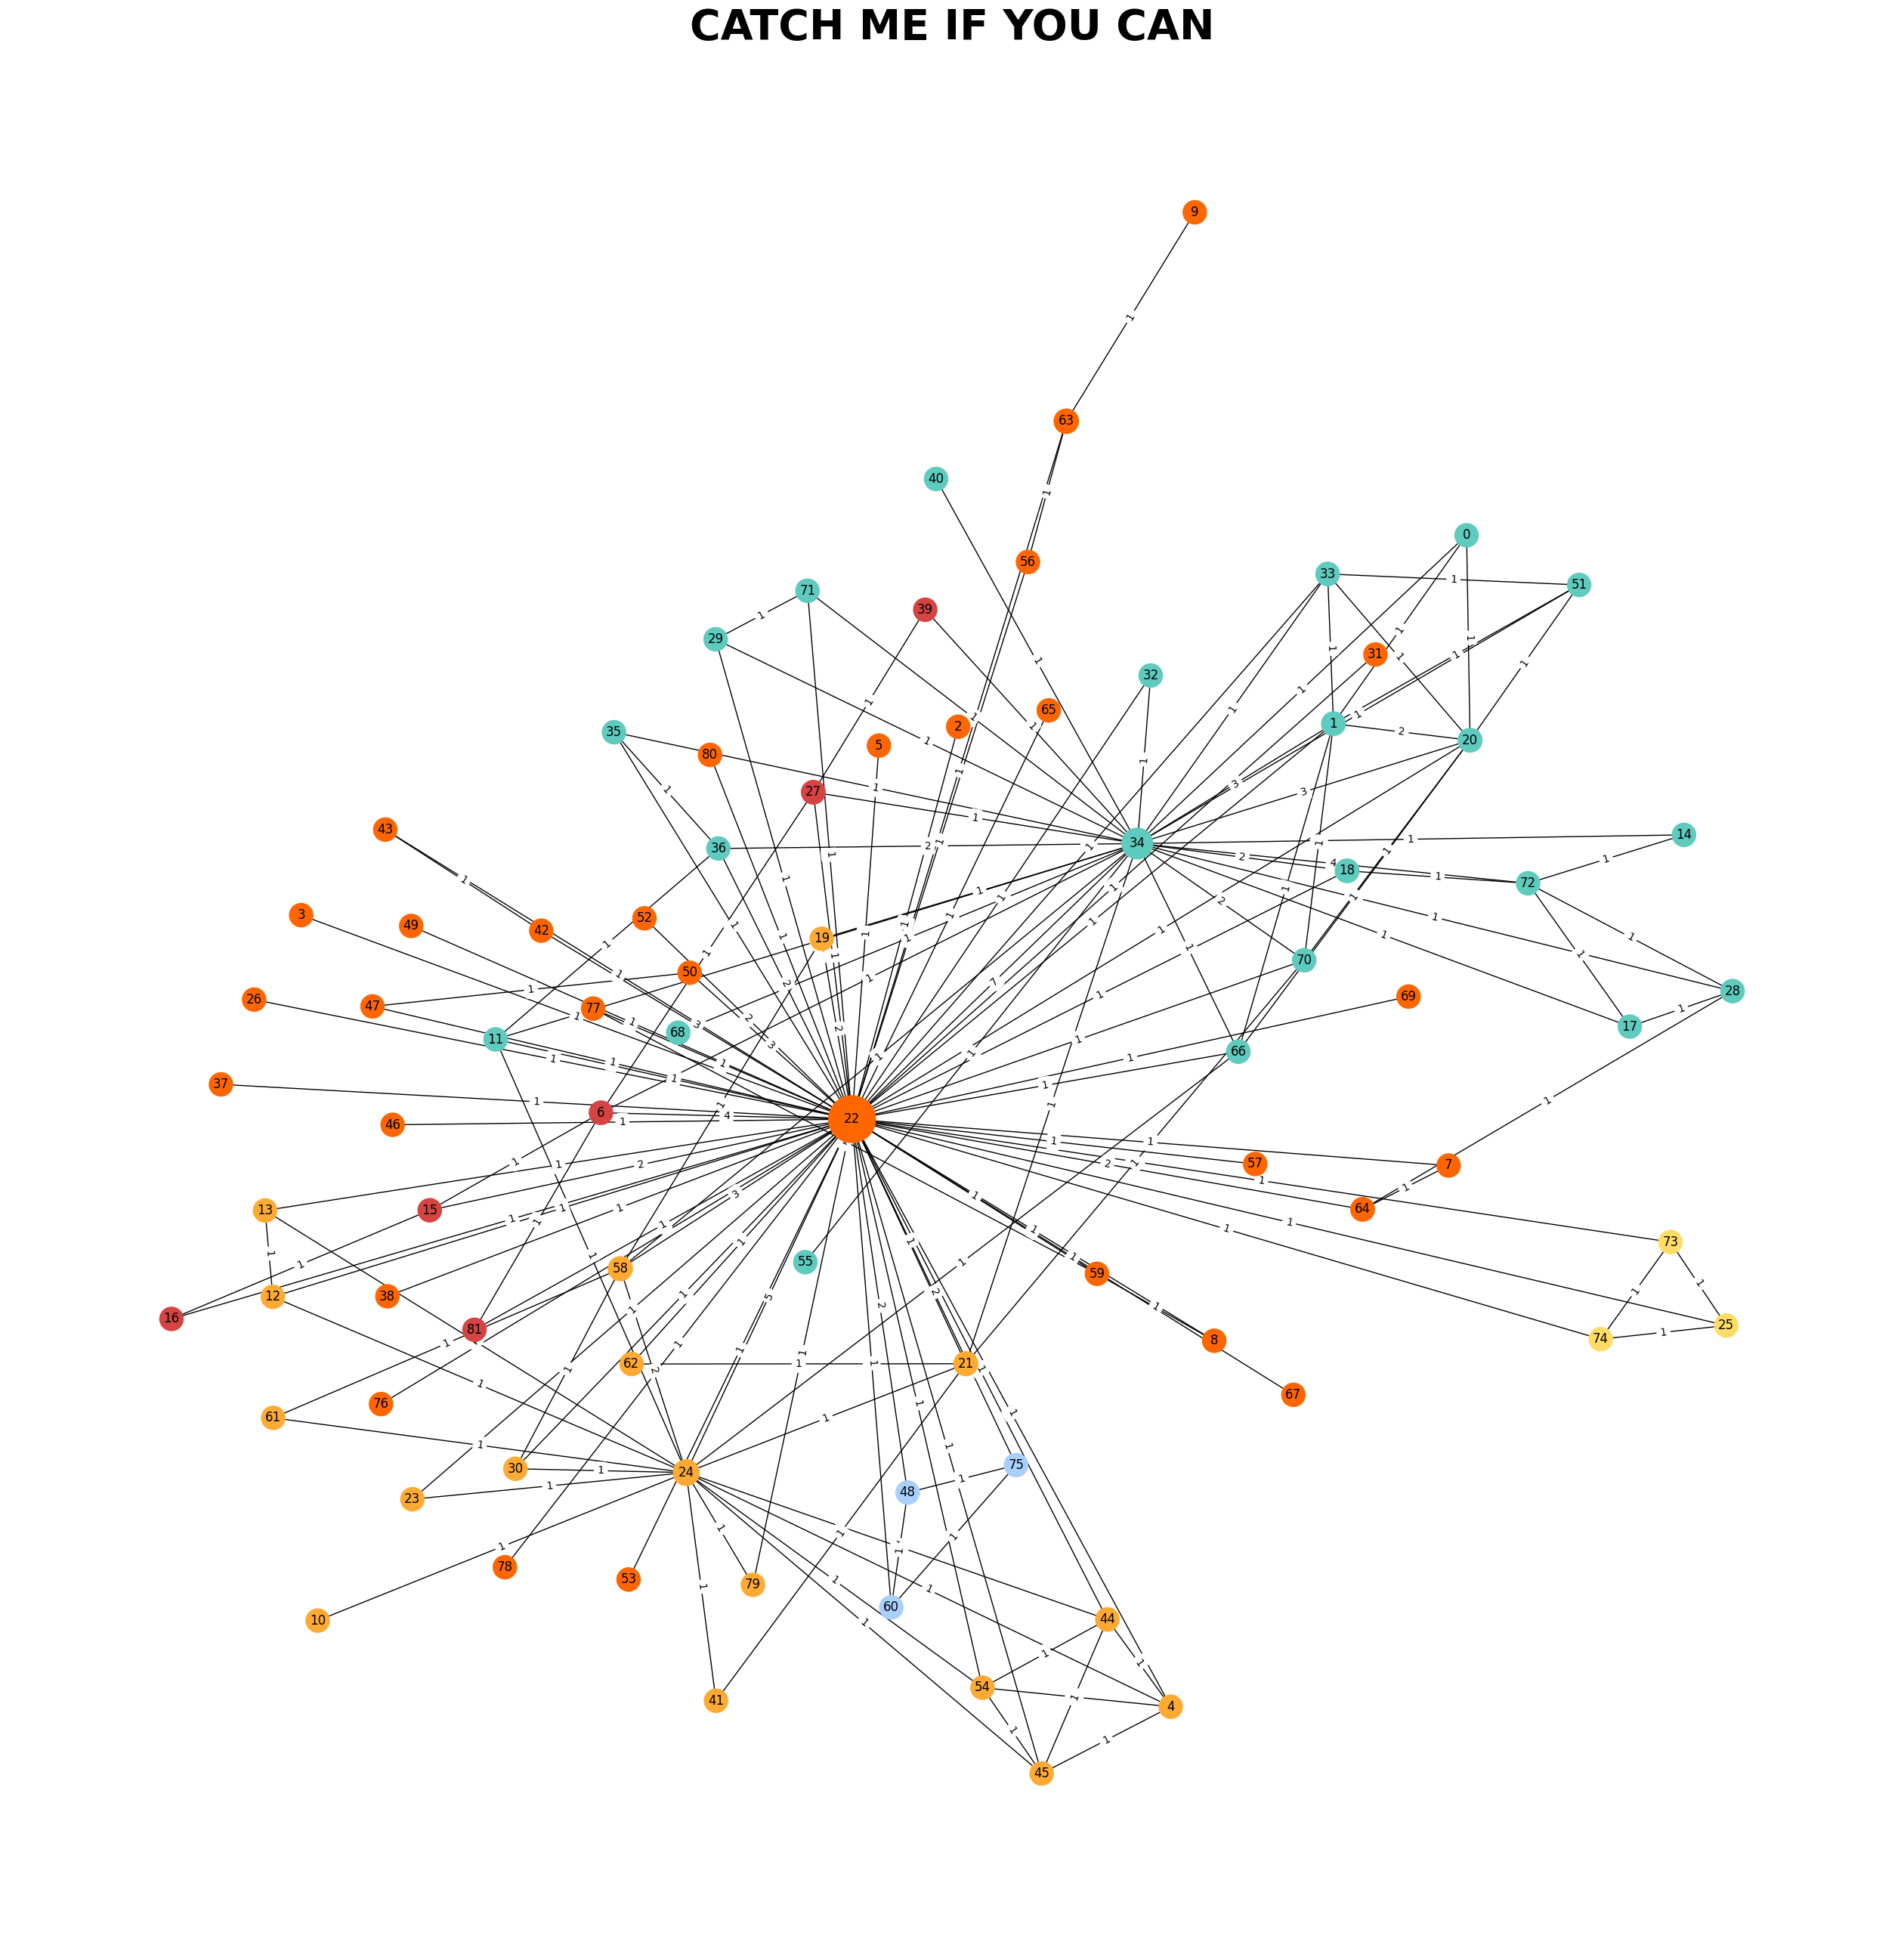

In [ ]:

plt.figure(figsize=(25, 25))
nx.draw(G, pos=positions, node_color=colors, node_size=sizes, with_labels=True)
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels)
plt.title('CATCH ME IF YOU CAN', size=40, weight='bold')
plt.show()


NUMBER OF NODES, NUMBER OF EDGES, AVERAGE DEGREE AND THE DENSITY

In [ ]:
n = G.number_of_nodes()
m = G.number_of_edges()
print("Number of nodes: ", n)
print("Number of edges: ", m)

Number of nodes:  82
Number of edges:  162


the degree k(v)
of a node v is computed by iterating over each edge in the edges_df dataframe
and incrementing the degree count for both the source and target nodes.
Given an edge \((u, v)\) from the dataframe `edges_df`:
$$
k(u) = k(u) + 1
$$
$$
k(v) = k(v) + 1
$$
where \( k(u) \) and \( k(v) \) are the degrees of nodes \( u \) and \( v \) respectively.






The average degree
⟨k⟩ is computed by summing up the degrees of all nodes and dividing by the total number of nodes.
$$
\langle k \rangle = \frac{\sum_{v \in V} k(v)}{N}
$$
where \( N \) is the total number of nodes in the graph and \( k(v) \) is the degree of node \( v \).


In [ ]:
def compute_degrees(edges_df):
    degrees = {}

    for index, row in edges_df.iterrows():
        source = row['# source']
        target = row[' target']

        degrees[source] = degrees.get(source, 0) + 1
        degrees[target] = degrees.get(target, 0) + 1

    return degrees

def compute_average_degree(edges_df):
    degrees = compute_degrees(edges_df)
    total_degree = sum(degrees.values())
    N = len(degrees)

    return total_degree / N


In [ ]:
print("Average degree: ", compute_average_degree(edges_df))

Average degree:  3.951219512195122


The formula for the density \( D \) of an undirected graph is:

$$
D = \frac{2M}{N(N-1)}
$$

Where:
- \( M \) is the number of edges in the graph.
- \( N \) is the number of nodes in the graph.


In [ ]:
def density(G):
    n = len(G.nodes())
    m = len(G.edges())
    if n == 0 or n == 1:
        return 0.0
    density = (2 * m) / (n * (n - 1))

    return density
print('Density:', density(G))

Density: 0.04878048780487805


<a id='week2'></a>
**WEEK 2 ANALYSIS** -

While considering the largest component of your network. Depending on what you prefer/seems
more relevant in your graph

**- Compute Average clustering and Transitivity number**

**- Implement a function computing the transitivity using basic function of networkx**

DIJKSTRA’S ALGORITHM

In [ ]:
def dijkstra_generic(G, start_node, use_weights=True):
    distances = {node: float('inf') for node in G.nodes()}
    distances[start_node] = 0
    pq = [(0, start_node)]
    while pq:
        current_distance, current_node = heapq.heappop(pq)
        for neighbor, edge_attr in G[current_node].items():
            weight = edge_attr['weight'] if use_weights else 1
            new_distance = current_distance + 1/weight
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                heapq.heappush(pq, (new_distance, neighbor))
    return distances
all_unweighted_shortest_path_lengths = {node: dijkstra_generic(G, node, use_weights=False)
                                        for node in G.nodes()}
all_weighted_shortest_path_lengths = {node: dijkstra_generic(G, node, use_weights=True)
                                      for node in G.nodes()}


Given the nature of the data (same-scene appearances), the average clustering and transitivity seemed be more relevant to us. These metrics would provide a clearer picture of character interactions and how characters are grouped or clustered in the narrative. It would highlight which characters frequently share scenes and are thus likely central to the movie's main plot or subplots.

We, thus, implemented a first function which retrieves the number of triangles in the graph. This is done by iterating over each node in the graph and counting the number of triangles that the node is part of. The number of triangles is then divided by the number of connected triples in the graph to get the transitivity.

**TRIANGLES** -
$$
\{u, v, w\} \text{ forms a triangle if } (u, v), (v, w), \text{ and } (u, w) \text{ are edges in the graph}
$$

**TRANSITIVITY** -
$$
T = \frac{3 \times \text{triangles\_count}}{\text{wedges}}
$$
Where:
'TRIANGLES COUNT' is the number of unique triangles in the graph and
'WEDGES' is the sum of the number of pairs of neighbors for each node in the graph.


In [ ]:
def find_triangles(G):
    triangles = set()
    for u, v in G.edges():
        # Find common neighbors
        common_neighbors = set(G.neighbors(u)).intersection(G.neighbors(v))
        for w in common_neighbors:
            triangle = tuple(sorted([u, v, w]))
            triangles.add(triangle)
    return triangles


triangles_in_graph = find_triangles(G)
def custom_transitivity_from_triangles(G, triangles_set):
    triangles_count = len(triangles_set)  # Count of unique triangles
    triples = sum(len(list(nx.ego_graph(G, v))) * (len(list(nx.ego_graph(G, v))) - 1) for v in G) / 2
    if triples == 0:
        return 0
    return (3 * triangles_count) / triples

custom_trans_from_triangles = custom_transitivity_from_triangles(G, triangles_in_graph)

We then implemented a second function which computes the average clustering coefficient of the graph. This is done by iterating over each node in the graph and computing the clustering coefficient of the node.

**Clustering Coefficient for a Node**:
For a given node \( v \) with degree \( k \):
$$
C(v) = \frac{2T(v)}{k(k-1)}
$$
Where \( T(v) \) is the number of triangles involving node \( v \).

The clustering coefficient of the node is then added to the total clustering coefficient of the graph. The total clustering coefficient is then divided by the number of nodes in the graph to get the average clustering coefficient.

**Average Clustering Coefficient**:
For the entire graph \( G \):
$$
C = \frac{1}{n} \sum_{v \in V} C(v)
$$
Where \( n \) is the number of nodes in \( G \) and \( V \) is the set of nodes.

In [ ]:
def avg_clustering(G):
    triangles_set = find_triangles(G)
    total_clustering_coeff = 0

    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        k = len(neighbors)
        if k < 2:
            continue
        # Count triangles involving the node
        T = sum(1 for triangle in triangles_set if node in triangle)
        total_clustering_coeff += 2 * T / (k * (k - 1))
    return total_clustering_coeff / len(G.nodes())

avg_clustering_custom = avg_clustering(G)
avg_clustering_custom


0.5990508780501608

<a id='week3'></a>
**WEEK 3 ANALYSIS** -

Depending on what seems more relevant in your graph, pick one of the following local notions

- *Decay centrality*
  
- *Betweeness centrality*
  
- *Closeness centrality*
  
- *Clustering*
  
- *Any other notions that you invent*
  
**1) Provide a code computing the given centrality using basic functions of networkx (you are not allowed to use directly nx."what you want").**

**2) Discuss why you picked this measure and who is the most central in your network based on your  choice.**

**3) Provide the cumulative distribution for this centrality and give a graphical representation of your graph(log-log, log or normal representation as you think it is more relevant).**

**CLOSENESS CENTRALITY**
could be a relevant approach in our analysis. It would allow us to identify the characters who are most central to the narrative. These characters would be the ones who are most likely to be involved in the main plot or subplots of the movie.

Therefore, given the following formula for the **Closeness Centrality**:

$$ C(u) = \frac{n - 1}{\sum_{v \neq u} d(v, u)} $$

This is the corresponding implementation:

In [ ]:
def custom_closeness_centrality(G):
    closeness_centrality = {}
    N = len(G.nodes)

    for u in G.nodes:
        sp_length = dijkstra_generic(G, u)
        n = len(sp_length)
        closeness_centrality[u] = (n - 1) / (N - 1) if n != 1 else 0.0
        closeness_centrality[u] /= sum(sp_length.values()) if n != 1 else 1.0

    return closeness_centrality
closeness_centrality_custom = custom_closeness_centrality(G)
most_central_character = max(closeness_centrality_custom, key=closeness_centrality_custom.get)

print('Most central character:', most_central_character)
print('Closeness centrality:', closeness_centrality_custom[most_central_character])


Most central character: 22
Closeness centrality: 0.013585198602665282


It results that our protagonist (node 22) has relatively low closeness centrality, shich suggest that the character is not closely connected to many other characters in the movie, indicating a potential narrative focus on isolated or introspective journeys, distinct subplots or a fragmented narrative.

**DISPLAYING THE CLOSENESS CENTRALITY FOR EACH NODE**

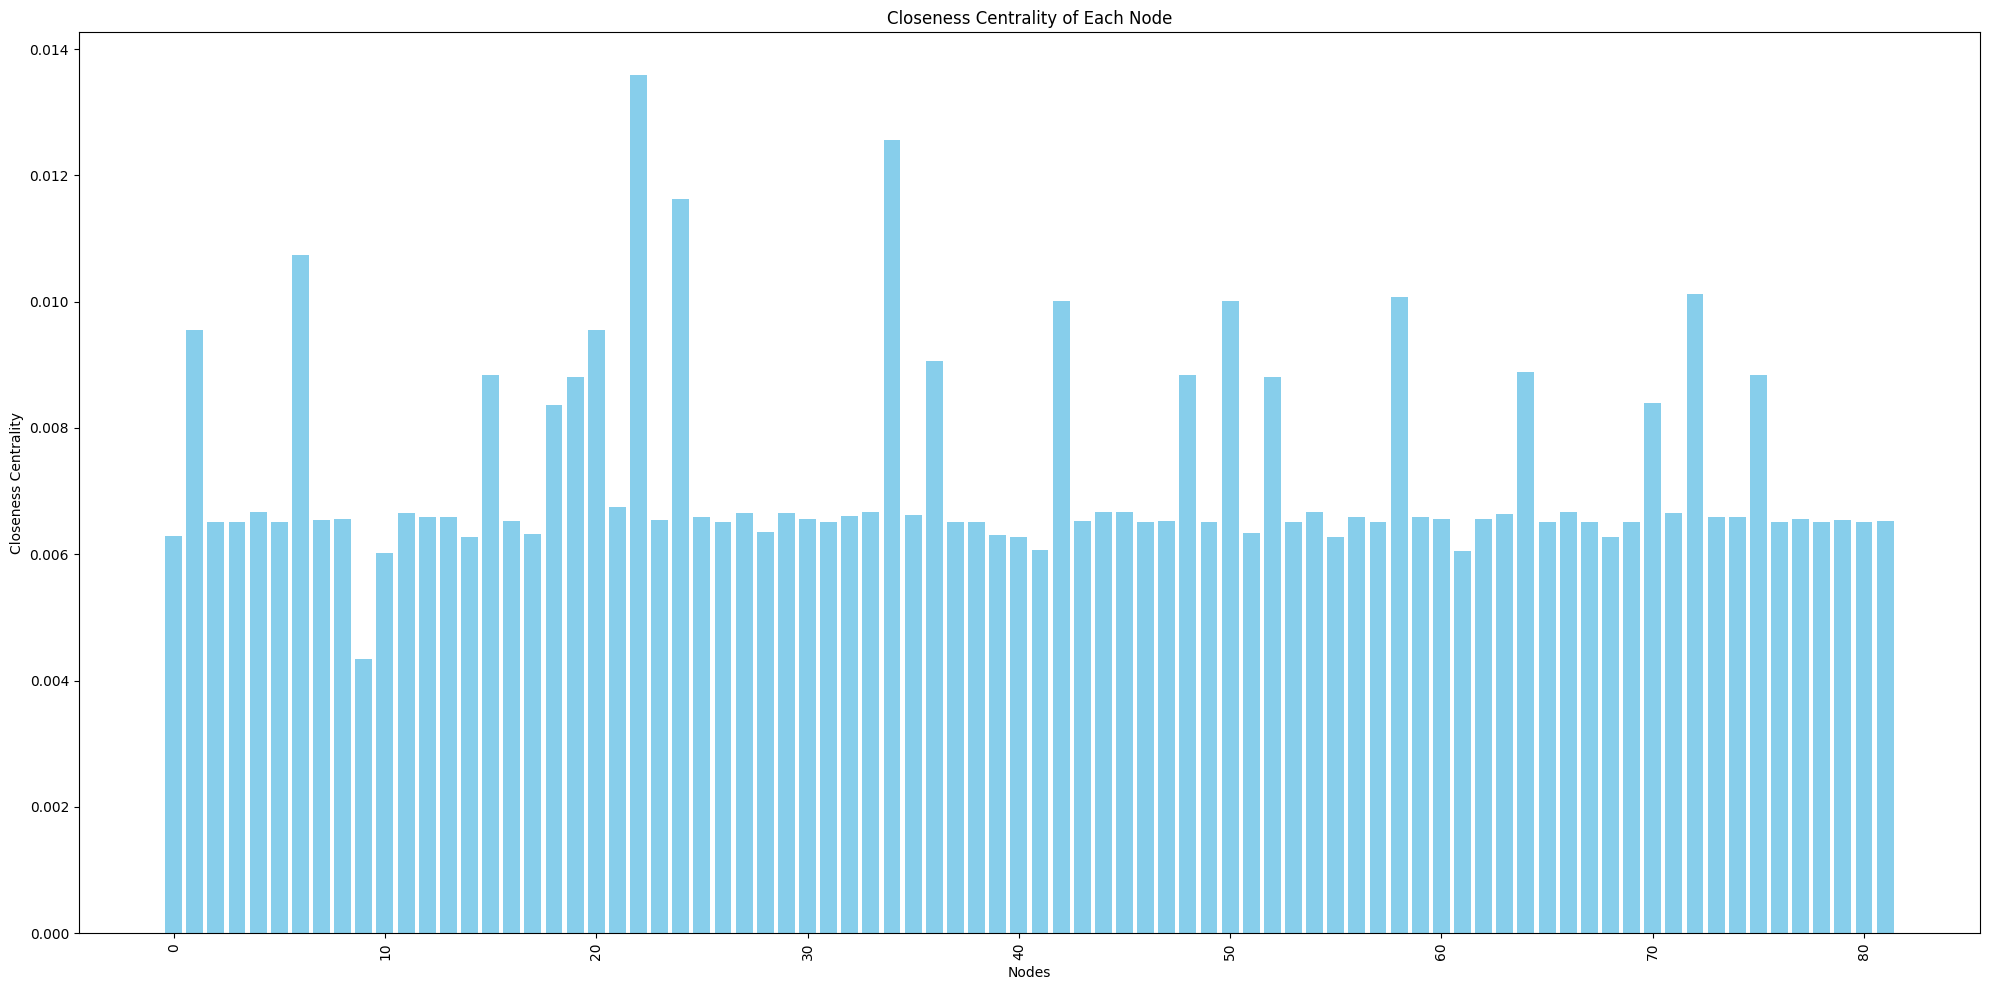

In [ ]:
nodes = list(closeness_centrality_custom.keys())
closeness_values = list(closeness_centrality_custom.values())

plt.figure(figsize=(20,10))
plt.bar(nodes, closeness_values, color='skyblue')
plt.xlabel('Nodes')
plt.ylabel('Closeness Centrality')
plt.title('Closeness Centrality of Each Node')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


**DISPLAYING THE CUMULATIVE DISTRIBUTION FOR THE CLOSENESS CENTRALITY**

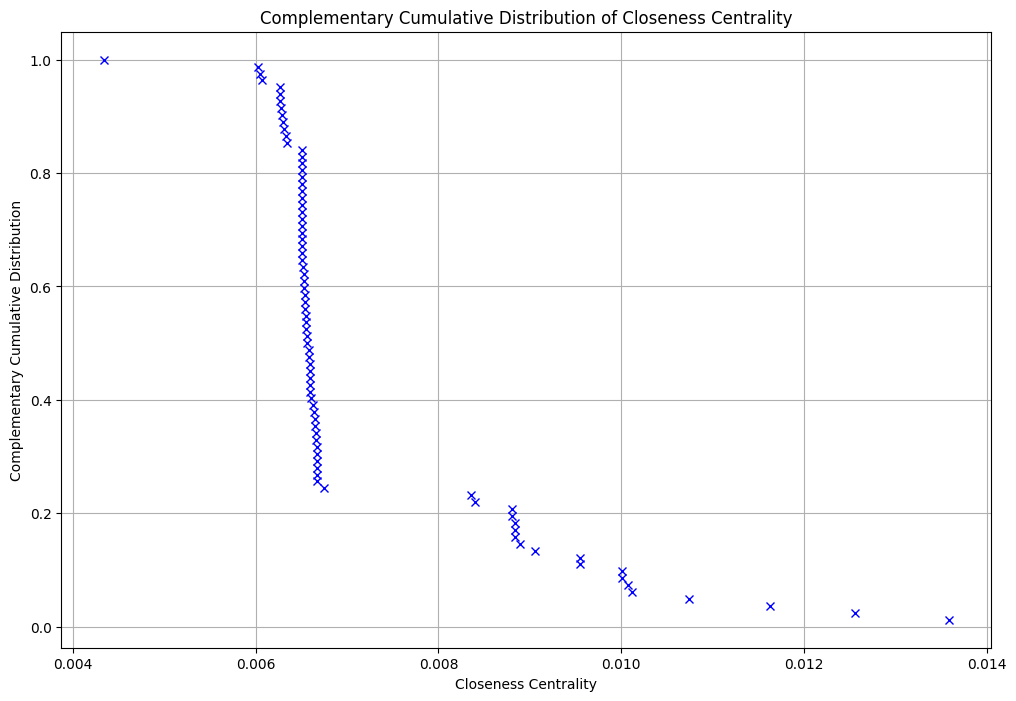

In [ ]:
closeness_values = sorted(list(closeness_centrality_custom.values()))

ccdf_y = np.arange(1, len(closeness_values) + 1)[::-1] / len(closeness_values)
ccdf_x = closeness_values

plt.figure(figsize=(12,8))
plt.plot(ccdf_x, ccdf_y, "x", color='blue')
plt.xlabel('Closeness Centrality')
plt.ylabel('Complementary Cumulative Distribution')
plt.title('Complementary Cumulative Distribution of Closeness Centrality')
plt.grid(True, which="both")
plt.show()


<a id='week5'></a>
#WEEK 5 ANALYSIS#
  

**1) Write a function to compute the PageRank of the nodes in a graph (you are not allowed to
use built-in functions from NetworkX).**


**2) Run it on your graph using ff = 0.15, save the total number of iterations, and check that
your function returns the same results (in terms of the scores) as the built-in function from
NetworkX.**


**3) Identify the node with the highest PageRank, compare it with the one you got from week 3,
and give an interpretation to the possible difference.**


**4) Provide the cumulative distribution, compare it with the one you got from week 3, and
comment the results.**


**5) Optional: Re-run the PageRank using ff = 0.5, save the total number of iterations, compare
with the results (in terms of both the number of iterations and the cumulative distribution)
obtained for ff = 0.15, and comment.**

In [ ]:
def pagerank(G, alpha, personalization,
             max_iter, tol, nstart, weight,
             dangling):

    if not G.is_directed():
        D = G.to_directed()
    else:
        D = G

    # Create a copy in (right) stochastic form
    W = nx.stochastic_graph(D, weight=weight)
    N = W.number_of_nodes()

    # Choose fixed starting vector if not given
    if nstart is None:
        x = dict.fromkeys(W, 1.0 / N)
    else:
        # Normalized nstart vector
        s = float(sum(nstart.values()))
        x = dict((k, v / s) for k, v in nstart.items())

    if personalization is None:

        # Assign uniform personalization vector if not given
        p = dict.fromkeys(W, 1.0 / N)
    else:
        missing = set(G) - set(personalization)
        if missing:
            raise NetworkXError('Personalization dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        s = float(sum(personalization.values()))
        p = dict((k, v / s) for k, v in personalization.items())

    if dangling is None:

        # Use personalization vector if dangling vector not specified (dandling nodes=nodes without outgoing links)
        dangling_weights = p
    else:
        missing = set(G) - set(dangling)
        if missing:
            raise NetworkXError('Dangling node dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        s = float(sum(dangling.values()))
        dangling_weights = dict((k, v/s) for k, v in dangling.items())
    dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0]

    # power iteration: make up to max_iter iterations
    for _ in range(max_iter):
        count=0
        xlast = x
        x = dict.fromkeys(xlast.keys(), 0)
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes)
        for n in x:
            for nbr in W[n]:
                x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
                count+=1
            x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * p[n]

        # check convergence, l1 norm
        err = sum([abs(x[n] - xlast[n]) for n in x])
        if err < N*tol:
          #returning the dict with values and also the max value
            return x, max(x.values()), count
    raise NetworkXError('pagerank: power iteration failed to converge '
                        'in %d iterations.' % max_iter)


pagerank(G, alpha=0.15, personalization=None,
             max_iter=100, tol=1.0e-6, nstart=None, weight='weight',
             dangling=None)



# Page Rank Implementation #

The PageRank algorithm, measures the importance of nodes in a graph. In this program we implemented it with some calculations:

**First statement:** check if it is a "directed" or "undirected" graph and in case, make it directed.

**Second statement:**  A stochastic version of the directed graph D is created, ensuring that the sum of weights of outgoing edges from each node is 1.

**Third statement:** choose a start node

**Fourth statement:** choose a personalization dict

**Fifth statement:** check on dandling nodes

**Sixth statement:** Power Iteration loop with a max_iteration_number set. A check of the convergence using L1 normalization is implemented.


In [ ]:
pagerank_scores = nx.pagerank(G, alpha=0.15)

print(pagerank_scores)

# PageRank Cumulative Distribution #
